In [1]:
import pandas as pd

In [78]:
labels_df = pd.read_csv('Dataset\Labels.csv')
agitation_df = labels_df[labels_df['type'] == 'Agitation']

sleep_df = pd.read_csv('Dataset\Sleep.csv')

In [79]:
sleep_df['date'] = pd.to_datetime(sleep_df['date'])
agitation_df['date'] = pd.to_datetime(agitation_df['date'])

sleep_df['agitation'] = 0

# Process agitation instances at 6pm
for index, row in agitation_df[agitation_df['date'].dt.hour == 18].iterrows():
    patient_id = row['patient_id']
    date = row['date'].normalize()  # Normalize to get the date without time for comparison

    # Mark sleep data between 12pm and 6pm on the same day with agitation = 1
    start_time = date + pd.Timedelta(hours=12)  # 12pm on the day of agitation
    end_time = date + pd.Timedelta(hours=18)  # 6pm on the day of agitation
    sleep_df.loc[(sleep_df['patient_id'] == patient_id) &
                 (sleep_df['date'] >= start_time) &
                 (sleep_df['date'] <= end_time), 'agitation'] = 1

# Process agitation instances at 12pm
for index, row in agitation_df[agitation_df['date'].dt.hour == 12].iterrows():
    patient_id = row['patient_id']
    date = row['date'].normalize()  # Normalize to get the date without time for comparison

    # Mark sleep data from 6pm of the previous day to 12pm of the day of agitation with agitation = 1
    start_time = date - pd.Timedelta(hours=6)  # 6pm on the previous day
    end_time = date + pd.Timedelta(hours=12)  # 12pm on the day of agitation
    sleep_df.loc[(sleep_df['patient_id'] == patient_id) &
                 (sleep_df['date'] > start_time) &
                 (sleep_df['date'] < end_time), 'agitation'] = 1

sleep_df['agitation'].value_counts()

C:\Users\youss\AppData\Local\Temp\ipykernel_37944\3125008001.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agitation_df['date'] = pd.to_datetime(agitation_df['date'])


agitation
0    449241
1     12182
Name: count, dtype: int64

In [80]:
sleep_df[sleep_df['agitation'] == 1]

,patient_id,date,state,heart_rate,respiratory_rate,snoring,agitation
2152,16f4b,2019-04-14 00:44:00,AWAKE,69.0,19.0,False,1
2153,16f4b,2019-04-14 00:45:00,AWAKE,56.0,13.0,False,1
2154,16f4b,2019-04-14 00:46:00,AWAKE,63.0,24.0,False,1
2155,16f4b,2019-04-14 00:47:00,AWAKE,65.0,15.0,False,1
2156,16f4b,2019-04-14 00:48:00,AWAKE,54.0,14.0,False,1
...,...,...,...,...,...,...,...
412290,ec812,2019-05-11 07:22:00,LIGHT,59.0,15.0,False,1
412291,ec812,2019-05-11 07:23:00,LIGHT,60.0,15.0,False,1
412292,ec812,2019-05-11 07:24:00,LIGHT,60.0,15.0,False,1
412293,ec812,2019-05-11 07:25:00,LIGHT,59.0,15.0,False,1


In [82]:
""" def determine_window_type(row):
    hour = row['date'].hour
    if 12 <= hour < 18:  # Afternoon window
        return 'afternoon'
    else:  # Nighttime window (considering hours outside 12-18 fall into the night window of the previous or current day)
        return 'night'

def window_end(row):
    if row['window_type'] == 'afternoon':
        return pd.Timestamp(row['date'].date()) + pd.Timedelta(hours=18)  # 6pm of the same day
    else:  # For nighttime, we adjust the end time based on if the time is before noon (ending today at noon) or after 6pm (ending tomorrow at noon)
        if row['date'].hour < 12:  # This part of the night window ends today at noon
            return pd.Timestamp(row['date'].date()) + pd.Timedelta(hours=12)
        else:
            return pd.Timestamp(row['date'].date() + pd.Timedelta(days=1)) + pd.Timedelta(hours=12) """

def window_start(row):
    hour = row['date'].hour
    if 12 <= hour < 18:  # Afternoon window
        window_type = 'afternoon'
    else:
        window_type = 'night'
        
    if window_type == 'afternoon':
        return pd.Timestamp(row['date'].date()) + pd.Timedelta(hours=12)
    else:  # For nighttime, we need to check if it's before or after midnight to adjust the start time accordingly
        if row['date'].hour < 12:  # This is part of the night window that starts on the previous day
            return pd.Timestamp(row['date'].date() - pd.Timedelta(days=1)) + pd.Timedelta(hours=18)
        else:
            return pd.Timestamp(row['date'].date()) + pd.Timedelta(hours=18)

# Apply the functions to determine window type, start, and end for each row
sleep_df['window_start'] = sleep_df.apply(window_start, axis=1)

In [83]:
aggregated_df = sleep_df.groupby(['patient_id', 'window_start'])
aggregated_df.head()

,patient_id,date,state,heart_rate,respiratory_rate,snoring,agitation,window_start
0,0f352,2019-06-25 22:53:00,AWAKE,69.0,14.0,False,0,2019-06-25 18:00:00
1,0f352,2019-06-25 22:54:00,AWAKE,66.0,14.0,False,0,2019-06-25 18:00:00
2,0f352,2019-06-25 22:55:00,AWAKE,70.0,14.0,False,0,2019-06-25 18:00:00
3,0f352,2019-06-25 22:56:00,AWAKE,70.0,13.0,False,0,2019-06-25 18:00:00
4,0f352,2019-06-25 22:57:00,AWAKE,68.0,13.0,False,0,2019-06-25 18:00:00
...,...,...,...,...,...,...,...,...
461320,f220c,2019-06-30 09:09:00,AWAKE,76.0,14.0,False,0,2019-06-29 18:00:00
461321,f220c,2019-06-30 09:10:00,AWAKE,73.0,18.0,False,0,2019-06-29 18:00:00
461322,f220c,2019-06-30 09:11:00,AWAKE,69.0,11.0,False,0,2019-06-29 18:00:00
461323,f220c,2019-06-30 09:12:00,AWAKE,75.0,11.0,False,0,2019-06-29 18:00:00


In [84]:
snoring_map = {True: 1, False: 0}
sleep_df['snoring'] = sleep_df['snoring'].map(snoring_map)

sleep_df['state'] = sleep_df['state'].str.lower()
states_map = {'awake': 0, 'light': 1, 'deep': 2, 'rem': 3}
sleep_df['state'] = sleep_df['state'].map(states_map)

In [85]:
sleep_df.to_csv('Dataset\Processed_Sleep.csv', index=False)

In [86]:
processed_sleep_df = pd.read_csv('Dataset\Processed_Sleep.csv')
processed_sleep_df['date'] = pd.to_datetime(processed_sleep_df['date'])

In [87]:
processed_sleep_df = processed_sleep_df.sort_values(by=['patient_id', 'date'])

In [93]:
def calculate_WASO(data):
    data_sorted = data.sort_values(by='date').reset_index(drop=True)
    
    # Find initial sleep onset and final awakening
    initial_sleep_onset_idx = data_sorted[(data_sorted['state'].shift(1) == 0) & (data_sorted['state'] != 0)].index.min()
    final_awakening_idx = data_sorted[(data_sorted['state'].shift(1) != 0) & (data_sorted['state'] == 0)].index.max()
    
    waso_duration = 0
    
    if pd.notna(initial_sleep_onset_idx) and pd.notna(final_awakening_idx):
        # Iterate from initial sleep onset to final awakening
        for i in range(initial_sleep_onset_idx, final_awakening_idx):
            current_record = data_sorted.iloc[i]
            next_record = data_sorted.iloc[i + 1]
            
            # Calculate time difference to next record
            time_diff = (next_record['date'] - current_record['date']).total_seconds() / 60  # convert to minutes
            
            # If state is awake (0) or if there is a missing timestamp (time_diff > 1 minute), add to WASO
            if current_record['state'] == 0 or time_diff > 1:
                # For missing data or explicit awake state, increment WASO by time_diff or 1 minute, respectively
                waso_duration += time_diff if time_diff > 1 else 1

    return waso_duration

def calculate_SOL(data):
    first_sleep_index = data[data['state'] != 0].index.min()  # Get the index of the first non-awake state
    if pd.notna(first_sleep_index):
        # Use .iloc to access rows by integer location
        sol_duration = (data.loc[first_sleep_index, 'date'] - data.iloc[0]['date']).total_seconds() / 60
        return sol_duration
    else:
        return 0
    
def calculate_TiB(data):
    # Calculate TiB as the difference between the last and first timestamps
    start_time = data['date'].iloc[0]
    end_time = data['date'].iloc[-1]
    TiB = (end_time - start_time).total_seconds() / 60  # Convert to minutes
    return TiB


def calculate_TST(data, tib, waso, sol):
    initial_sleep_onset_time = data.loc[(data['state'].shift(1) == 0) & (data['state'] != 0), 'date'].min()
    awake_before_sleep_onset = (initial_sleep_onset_time - data['date'].iloc[0]).total_seconds() / 60 if pd.notna(initial_sleep_onset_time) else 0
    
    # Calculate awake time after final awakening
    final_awakening_time = data.loc[(data['state'].shift(1) != 0) & (data['state'] == 0), 'date'].max()
    awake_after_final_awakening = (data['date'].iloc[-1] - final_awakening_time).total_seconds() / 60 if pd.notna(final_awakening_time) else 0
    
    # TST is TiB minus the sum of WASO, awake time before sleep onset, and awake time after final awakening
    TST = tib - (waso + sol + awake_after_final_awakening)
    
    return TST


def calculate_SE(data, tst, tib):
    if tib > 0:
        se_percentage = (tst / tib) * 100
        return se_percentage
    else:
        return 0

In [94]:
def calculate_metrics(group):
    metrics = {}

    metrics['mean_HR'] = group['heart_rate'].mean()
    metrics['HR_var'] = group['heart_rate'].std()
    metrics['mean_RR'] = group['respiratory_rate'].mean()
    metrics['RR_var'] = group['respiratory_rate'].std()
    
    metrics['WASO'] = calculate_WASO(group)
    metrics['SOL'] = calculate_SOL(group)
    metrics['TIB'] = calculate_TiB(group)
    metrics['TST'] = calculate_TST(group, metrics['TIB'], metrics['WASO'], metrics['SOL'])
    metrics['SE'] = calculate_SE(group, metrics['TST'], metrics['TIB'])
    metrics['snoring_counts'] = group['snoring'].sum()

    metrics['agitation'] = group['agitation'].max()  
    
    return pd.Series(metrics)

aggregated_df = processed_sleep_df.groupby(['patient_id', 'window_start']).apply(calculate_metrics).reset_index()



In [95]:
aggregated_df[aggregated_df['agitation'] == 1]

,patient_id,window_start,mean_HR,HR_var,mean_RR,RR_var,WASO,SOL,TIB,TST,SE,snoring_counts,agitation
10,16f4b,2019-04-13 18:00:00,62.223577,9.519626,14.321138,2.350536,246.0,15.0,387.0,108.0,27.906977,0.0,1.0
18,16f4b,2019-04-20 18:00:00,70.110837,6.473881,14.088670,2.058891,26.0,17.0,405.0,327.0,80.740741,3.0,1.0
19,16f4b,2019-04-21 18:00:00,63.283757,11.216572,15.438356,2.714452,80.0,8.0,529.0,336.0,63.516068,4.0,1.0
23,16f4b,2019-04-25 18:00:00,69.777414,6.212590,16.291326,2.285429,201.0,94.0,610.0,288.0,47.213115,0.0,1.0
45,16f4b,2019-05-09 18:00:00,71.997938,7.793963,15.896907,2.744960,142.0,100.0,484.0,193.0,39.876033,0.0,1.0
48,16f4b,2019-05-11 12:00:00,67.722222,6.350536,16.794444,2.432824,0.0,72.0,359.0,79.0,22.005571,0.0,1.0
49,16f4b,2019-05-11 18:00:00,68.510730,5.106060,16.394850,2.517542,392.0,0.0,953.0,493.0,51.731375,0.0,1.0
52,16f4b,2019-05-13 18:00:00,67.797633,5.795937,15.875740,2.515345,407.0,241.0,859.0,151.0,17.578580,0.0,1.0
316,93c14,2019-05-19 18:00:00,57.208547,3.604259,13.663248,1.312910,29.0,19.0,595.0,470.0,78.991597,27.0,1.0
321,93c14,2019-05-24 18:00:00,58.400697,4.784326,14.398955,1.637070,206.0,6.0,683.0,466.0,68.228404,35.0,1.0


In [96]:
aggregated_df.to_csv('Dataset\Aggregated_Sleep.csv', index=False)

<Axes: >

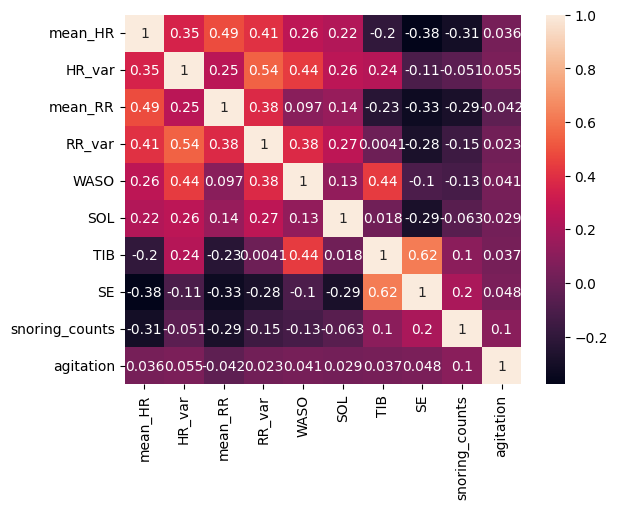

In [7]:
import seaborn as sns

agg_sleep_df = pd.read_csv('Dataset\Aggregated_Sleep.csv')

correlation = agg_sleep_df.loc[:,~agg_sleep_df.columns.isin(['patient_id','window_start','TST'])].corr()
sns.heatmap(correlation, annot=True)

In [5]:
agg_sleep_df.loc[:,~agg_sleep_df.columns.isin(['patient_id','window_start'])]

,mean_HR,HR_var,mean_RR,RR_var,WASO,SOL,TIB,TST,SE,snoring_counts,agitation
0,65.039514,3.345222,11.917933,1.348875,270.0,10.0,540.0,204.0,37.777778,0.0,0.0
1,67.176030,2.739798,11.456929,0.992935,124.0,19.0,349.0,179.0,51.289398,0.0,0.0
2,64.623583,3.076862,11.977324,1.061488,222.0,15.0,569.0,238.0,41.827768,0.0,0.0
3,62.416667,4.372302,11.397849,1.110011,61.0,13.0,401.0,309.0,77.057357,80.0,0.0
4,68.082569,2.632167,13.330275,1.171064,77.0,12.0,149.0,49.0,32.885906,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
921,65.824818,5.864772,20.445255,2.348090,19.0,32.0,143.0,44.0,30.769231,0.0,0.0
922,74.025090,6.879007,20.763441,4.264330,351.0,11.0,755.0,42.0,5.562914,0.0,0.0
923,63.159574,4.886460,20.053191,3.329138,0.0,0.0,148.0,28.0,18.918919,0.0,0.0
924,68.135762,5.172581,17.943709,3.200936,12.0,14.0,439.0,6.0,1.366743,0.0,0.0


In [10]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

agg_sleep_df = agg_sleep_df.dropna()

X = agg_sleep_df.loc[:,~agg_sleep_df.columns.isin(['patient_id','window_start','agitation'])]
y = agg_sleep_df['agitation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to oversample the minority class
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [ ]:
# # Correctly assembling a new test set that includes all 'Agitation' instances not used in training

# # Retrieve all indices for 'Agitation' samples from the original dataset
# all_agitation_indices = agg_sleep_df[agg_sleep_df['agitation'] == 1].index

# # Find indices of 'Agitation' that were not used in training
# unused_agitation_indices = all_agitation_indices.difference(train_indices_oversampled)

# # Combine these unused 'Agitation' indices with the previously calculated correct_unused_indices for 'No Agitation'
# final_test_indices = unused_agitation_indices.union(correct_unused_indices)

# # Create the final new test set using these indices
# final_new_test_set = data_model.loc[final_test_indices]
# X_final_new_test = final_new_test_set.drop('agitation', axis=1)
# y_final_new_test = final_new_test_set['agitation']

# # Check the distribution of the final corrected new test set
# y_final_new_test.value_counts()


# # Manually oversample the minority class to achieve a more balanced dataset
# agitation_1_oversampled = agitation_1.sample(n=len(agitation_0), replace=True, random_state=42)  # Duplicate minority samples

# # Combine the oversampled minority class with the original majority class
# oversampled_data = pd.concat([agitation_1_oversampled, agitation_0])

# # Split the oversampled dataset into features and target
# X_oversampled = oversampled_data.drop('agitation', axis=1)
# y_oversampled = oversampled_data['agitation']

# # Split the oversampled dataset into training and test sets
# X_train_oversampled, X_test_oversampled, y_train_oversampled, y_test_oversampled = train_test_split(
#     X_oversampled, y_oversampled, test_size=0.3, random_state=42
# )

# # Initialize and train the RandomForest model on the oversampled data
# rf_model_oversampled = RandomForestClassifier(random_state=42)
# rf_model_oversampled.fit(X_train_oversampled, y_train_oversampled)

# # Predictions and evaluation for the oversampled dataset
# y_pred_oversampled = rf_model_oversampled.predict(X_test_oversampled)
# classification_results_oversampled = classification_report(y_test_oversampled, y_pred_oversampled, target_names=['No Agitation', 'Agitation'])

# classification_results_oversampled

In [18]:
efs = ExhaustiveFeatureSelector(RandomForestClassifier(),min_features = 4, max_features=10, scoring='roc_auc')

efs = efs.fit(X_train, y_train)

selected_features = X_train.columns[list(efs.best_idx_)]
print(selected_features)

print(efs.best_score_)

Features: 848/848

Index(['mean_HR', 'HR_var', 'mean_RR', 'WASO', 'TIB', 'TST', 'snoring_counts'], dtype='object')
0.7672310025542783


In [13]:
y_train_resampled

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1439    1.0
1440    1.0
1441    1.0
1442    1.0
1443    1.0
Name: agitation, Length: 1444, dtype: float64

In [16]:
y_train_resampled[y_train_resampled == 0]

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
734    0.0
735    0.0
736    0.0
737    0.0
738    0.0
Name: agitation, Length: 722, dtype: float64